In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'          : '9',
    'date'       : '2022_09_14',
    'inTagIdent' : '_lTauPtCut18',
    'inTagCalib' : '_lTauPtCut18_uEtacut1.5',
    'caloClNxM'  : '5x9',
    'sparsity'   : 0.6
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']
identdir = indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']
calibdir = indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

sparsityTag = str(options['sparsity']).split('.')[0]+'p'+str(options['sparsity']).split('.')[1]

In [4]:
X1_id = np.load(identdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_id = np.load(identdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_id  = np.load(identdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_id = np.float32(X1_id)
X2_id = np.float32(X2_id)
Y_id = np.float32(Y_id)

X1_id_reduced = X1_id[:3000]
X2_id_reduced = X2_id[:3000]
Y_id_reduced = Y_id[:3000]

In [5]:
X1_cal = np.load(calibdir+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_cal = np.load(calibdir+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_cal  = np.load(calibdir+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_cal = np.float32(X1_cal)
X2_cal = np.float32(X2_cal)
Y_cal = np.float32(Y_cal)

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
Y_cal_reduced = Y_cal[:3000]

In [6]:
# quantized and pruned models
QCNN = keras.models.load_model(identdir+'/QCNNmodel'+sparsityTag+'Pruned', compile=False)
QDNNident = keras.models.load_model(identdir+'/QDNNmodel'+sparsityTag+'Pruned', compile=False)
QDNNcalib = keras.models.load_model(calibdir+'/TauCNNQCalibrator'+sparsityTag+'Pruned', compile=False)

2022-09-27 13:50:29.243883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2022-09-27 13:50:29.243926: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-27 13:50:29.244332: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

In [7]:
# original floating point model without pruning
CNN_FullFloat= keras.models.load_model(identdir+'/CNNmodel', compile=False)
DNNident_FullFloat= keras.models.load_model(identdir+'/DNNmodel', compile=False)
DNNcalib_FullFloat= keras.models.load_model(calibdir+'/TauCNNCalibrator', compile=False)

# QUANTIZED MODELS ONLY

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNpBNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': Tr

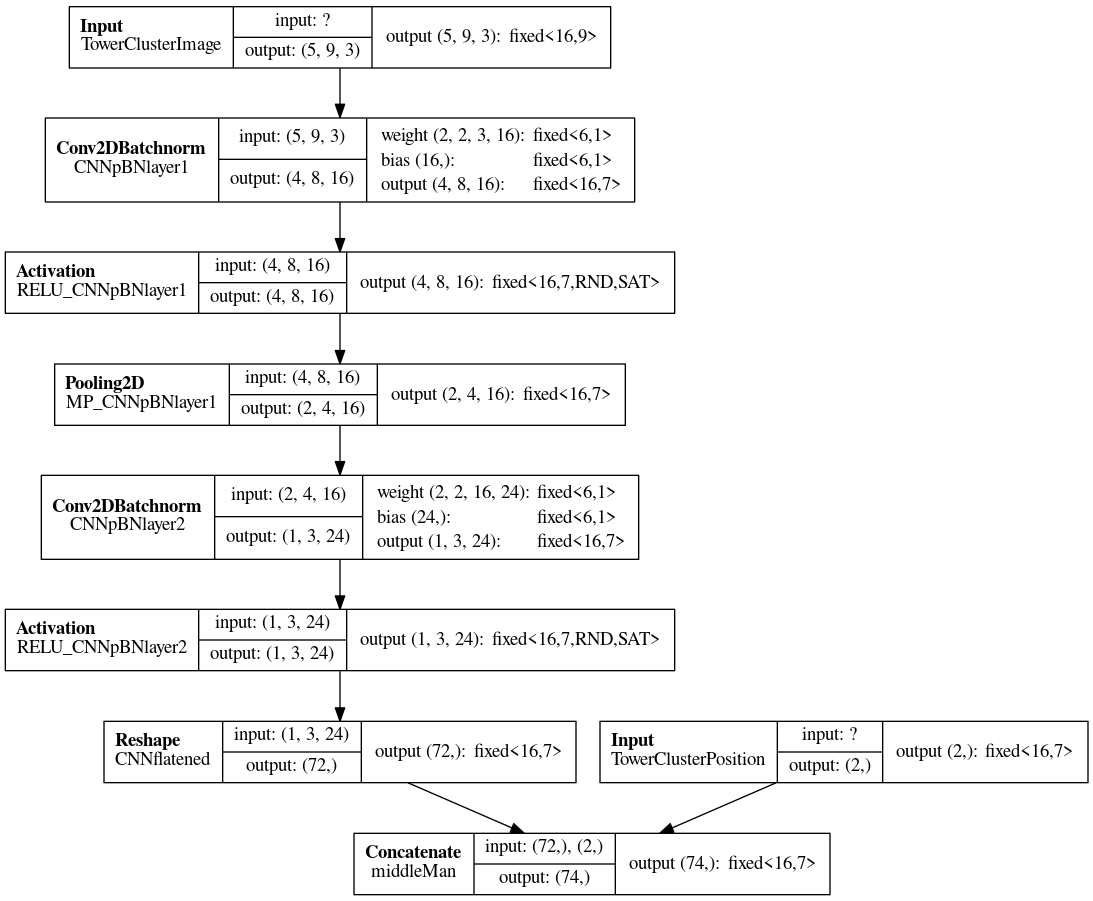

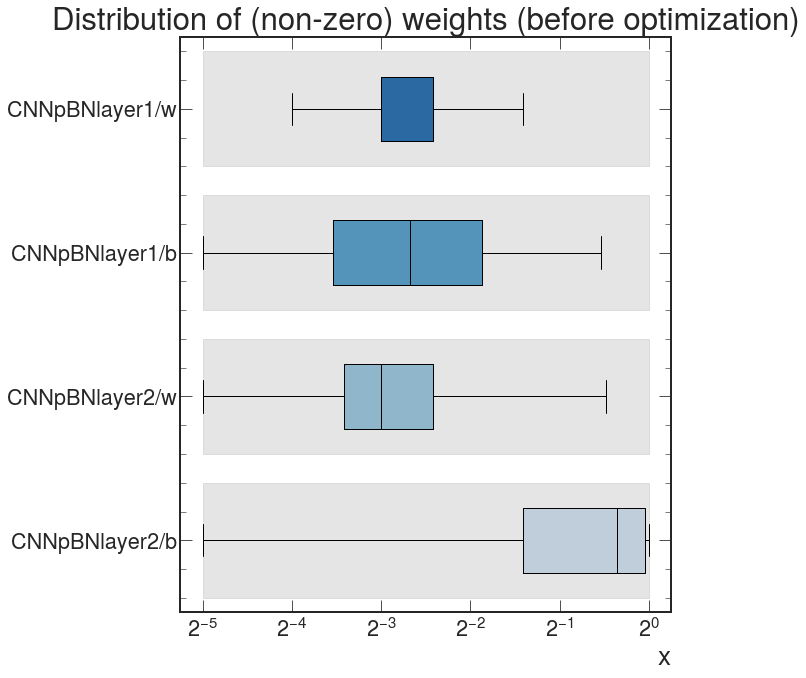

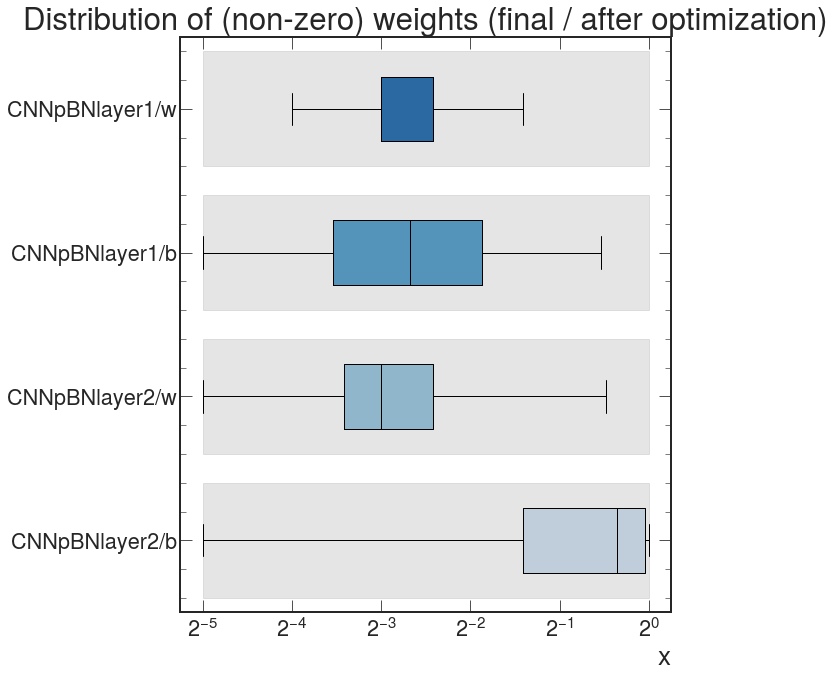

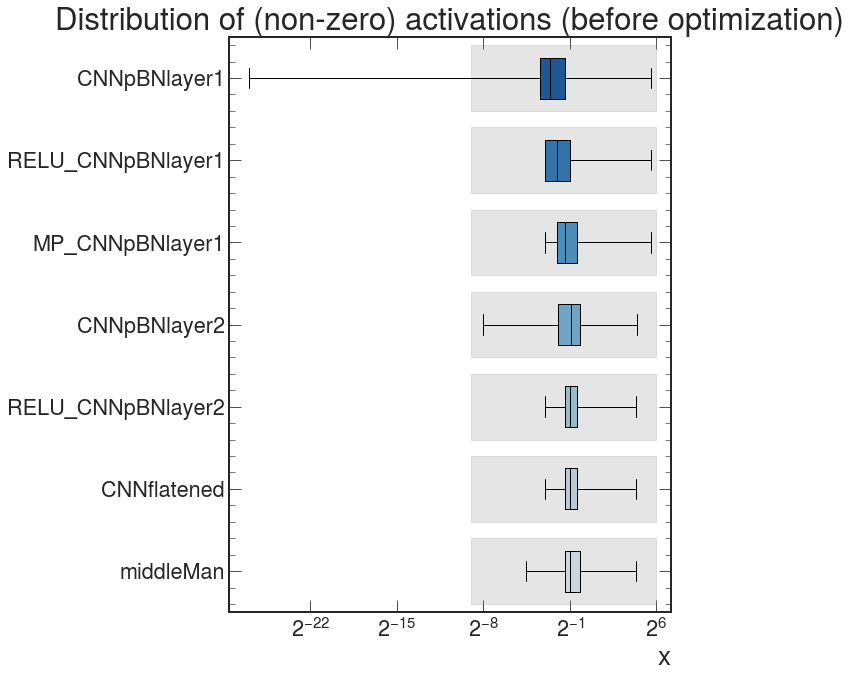

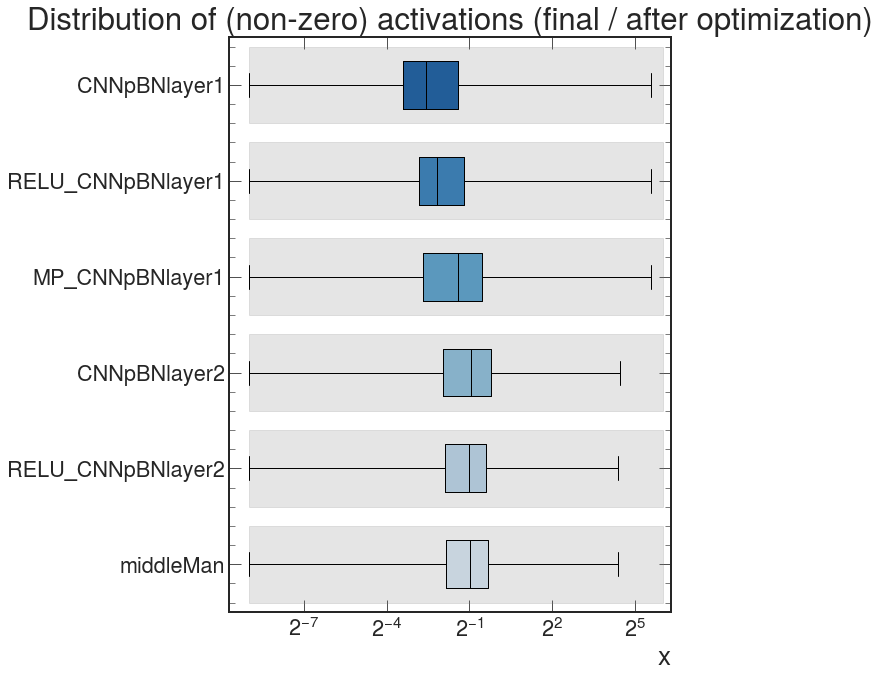

In [8]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    QCNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = identdir+'/QCNNmodel'+sparsityTag+'Pruned_HLS/'
QCNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': {'result': 'ap_fixed<16,6>'}, 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'result': 'ap_fixed<9,6>', 'accum': 'ap_fixed<13,5>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': T

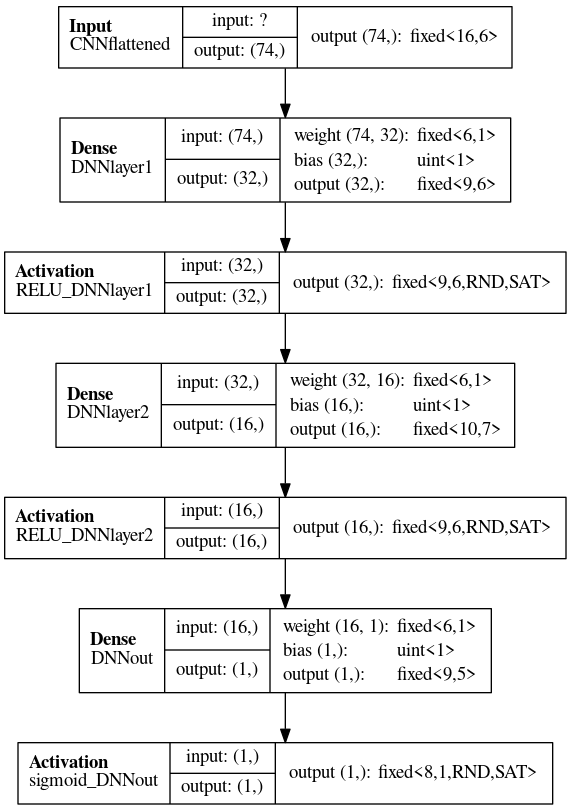

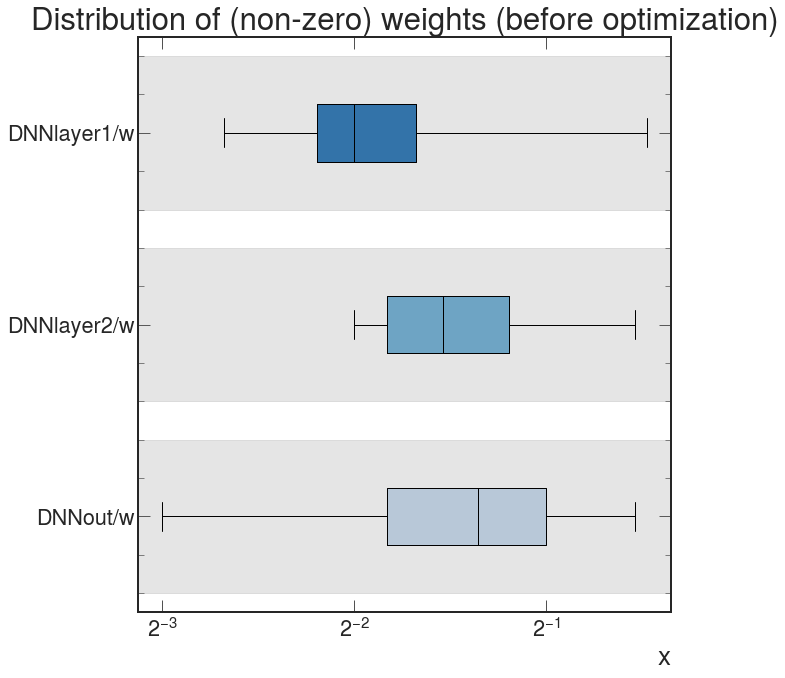

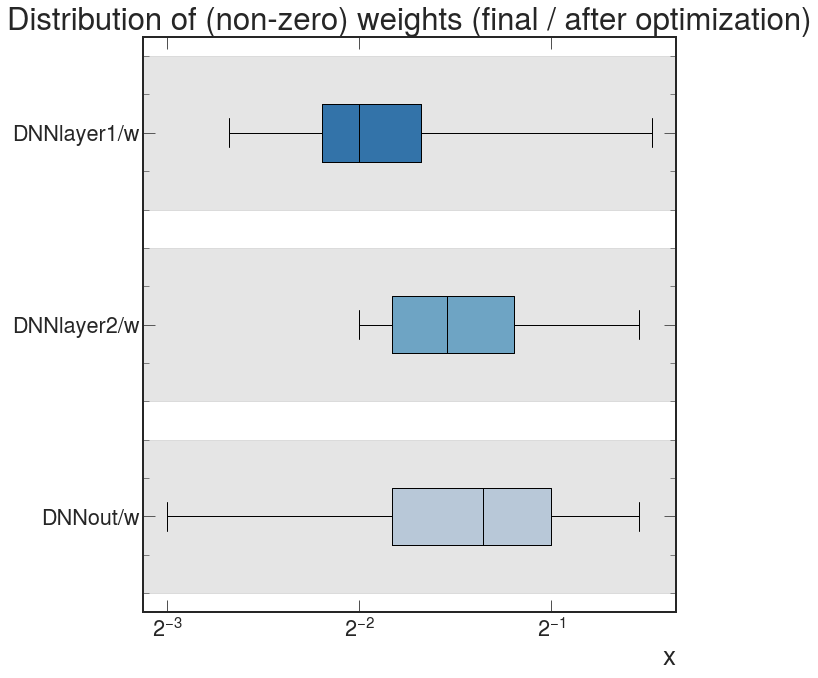

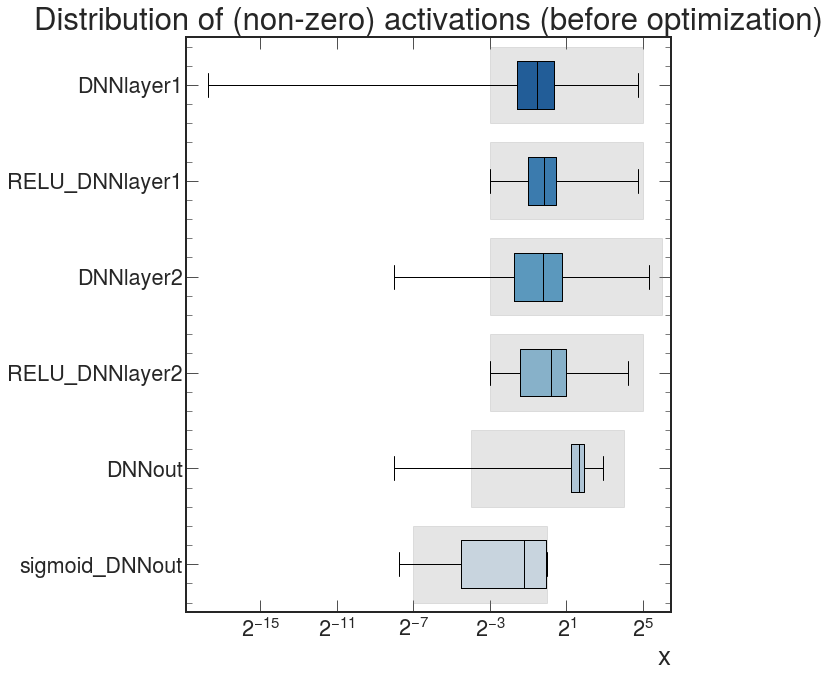

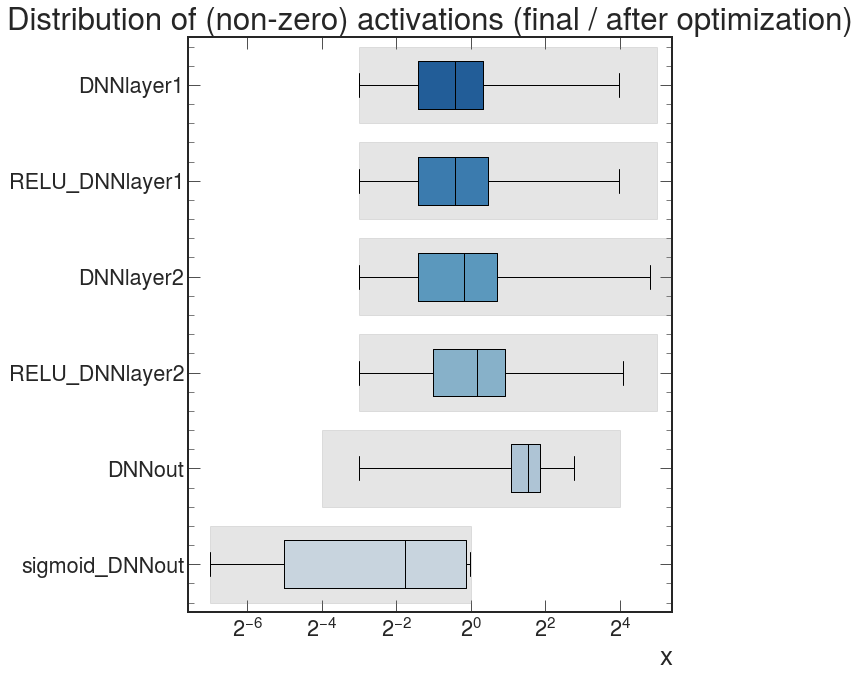

In [9]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<9,6>'
id_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<13,5>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<9,6>'

id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,1>'
id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<10,7>'
id_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<11,6>'
id_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<9,6>'

id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<9,5>'
id_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<7,4>'

id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_parallel'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = identdir+'/QDNNmodel'+sparsityTag+'Pruned_HLS/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<16,7>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,2>', 'result': 'ap_fixed<18,7>', 'accum': 'ap_fixed<16,5>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 

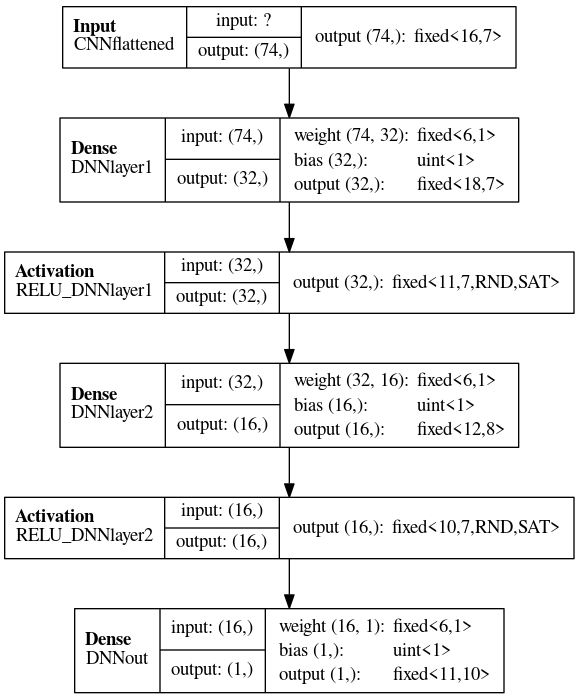

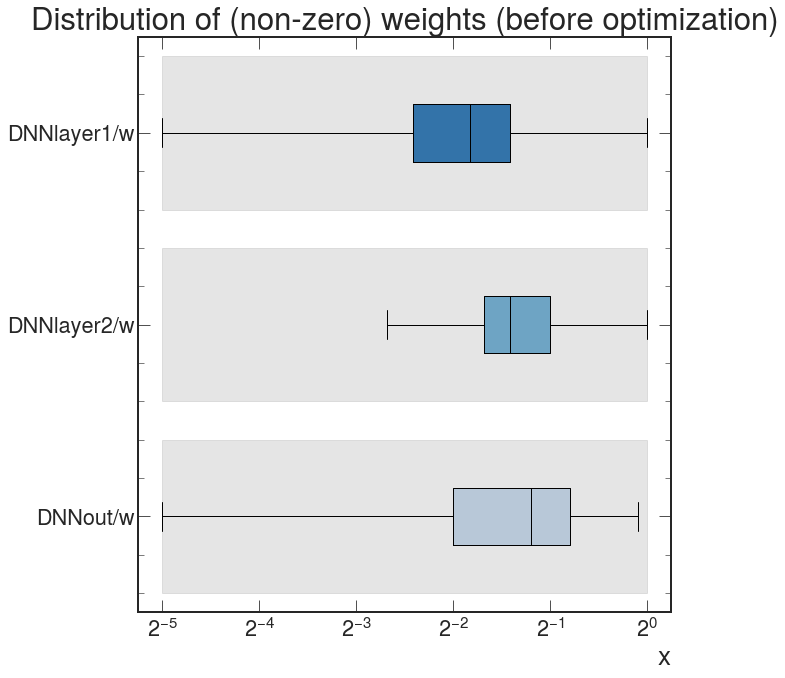

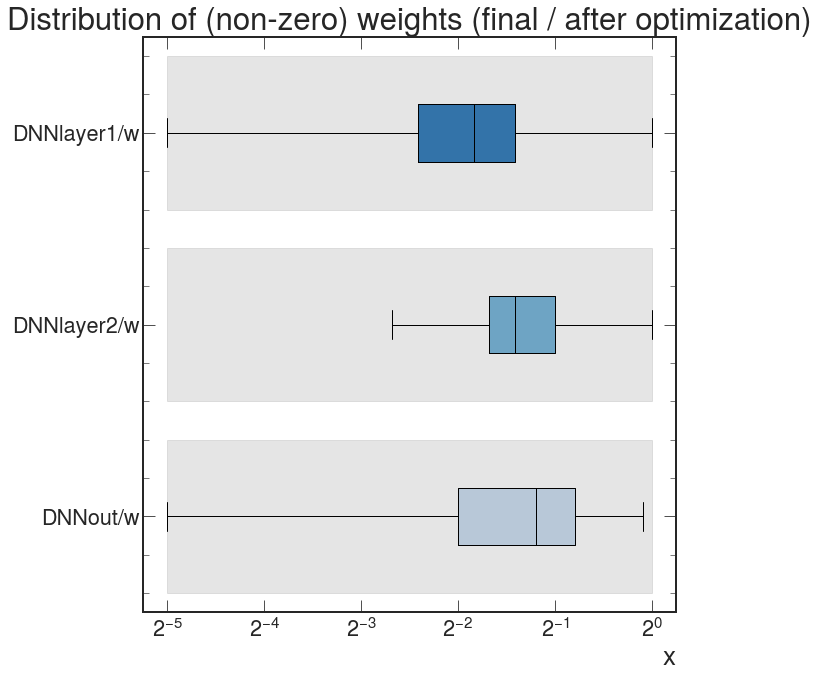

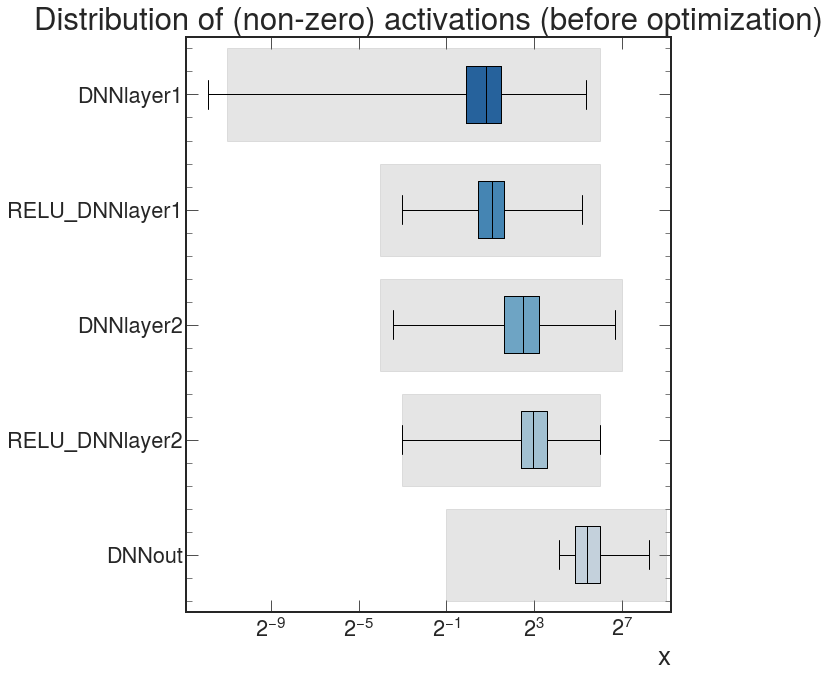

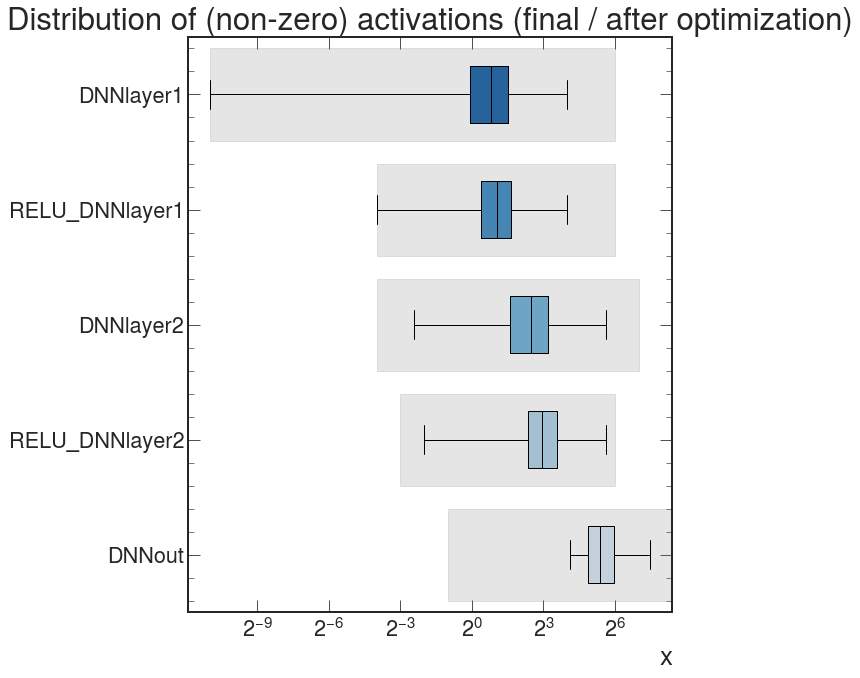

In [10]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<16,7>'
    
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<18,7>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['accum'] = 'ap_fixed<16,5>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<12,8>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['accum'] = 'ap_fixed<16,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<10,7>'

cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['accum'] = 'ap_fixed<16,9>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = calibdir+'/QDNNmodel'+sparsityTag+'Pruned_HLS/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [11]:
def plotROC(Y, y_pred, y_pred_hls4ml, y_pred_fullfloat, label="Model", Xrange=None, Yrange=None, Yscale=None):
    
    # accuracy_keras  = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred,axis=1), normalize=True))
    # accuracy_hls4ml = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1), normalize=True))
    # print("Accuracy Keras:  {}".format(accuracy_keras))
    # print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    FPR_FF, TPR_FF, THR_FF = metrics.roc_curve(Y, y_pred_fullfloat)
    AUC_FF = metrics.roc_auc_score(Y, y_pred_fullfloat)
    
    plt.plot(TPR_FF, FPR_FF, label='Keras Full Float ROC, AUC = %.3f' % (AUC_FF), color='red',lw=2)
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    plt.grid(linestyle=':')
    if Xrange: plt.xlim(Xrange)
    if Yrange: plt.ylim(Yrange)
    if Yscale: plt.yscale(Yscale)
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [12]:
y_ident_ff = DNNident_FullFloat.predict(CNN_FullFloat.predict([X1_id, X2_id]))
y_calib_ff = DNNcalib_FullFloat.predict(CNN_FullFloat.predict([X1_cal, X2_cal]))

In [13]:
y_ident_q        = QDNNident.predict(QCNN.predict([X1_id, X2_id]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1_id, X2_id]))

In [14]:
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal]))

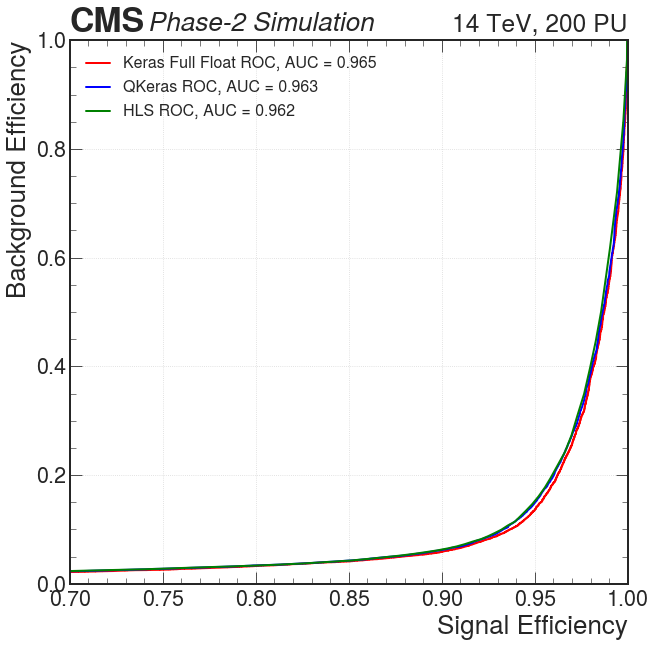

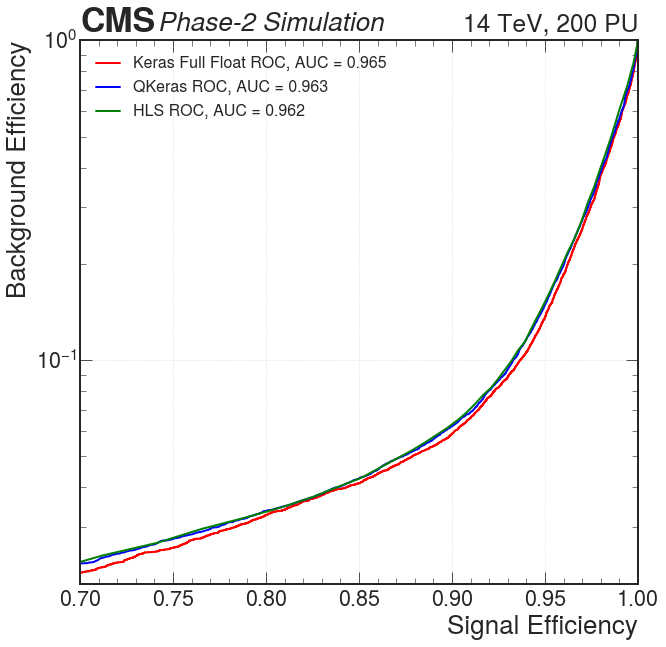

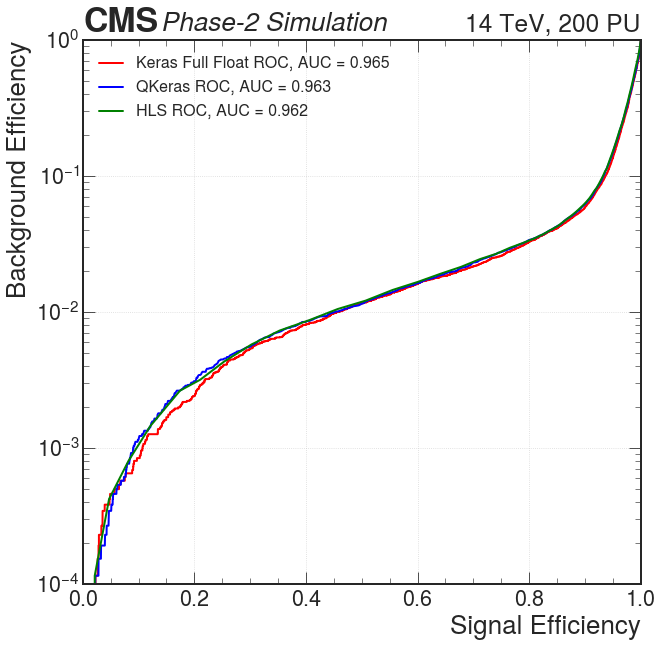

In [15]:
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Xrange=(0.7,1), Yrange=(0,1))
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Yscale="log", Xrange=(0.7,1), Yrange=(0.02,1))
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q, y_ident_ff, label="QKeras", Yscale="log", Xrange=(0.,1), Yrange=(0.0001,1))

In [16]:
ravelled = Y_cal[:,0]

response_q = y_calib_q.ravel() / ravelled
response_q_hls4ml = y_calib_hls4ml_q.ravel() / ravelled
response_ff = y_calib_ff.ravel() / ravelled

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Phase-2 Simulation'))

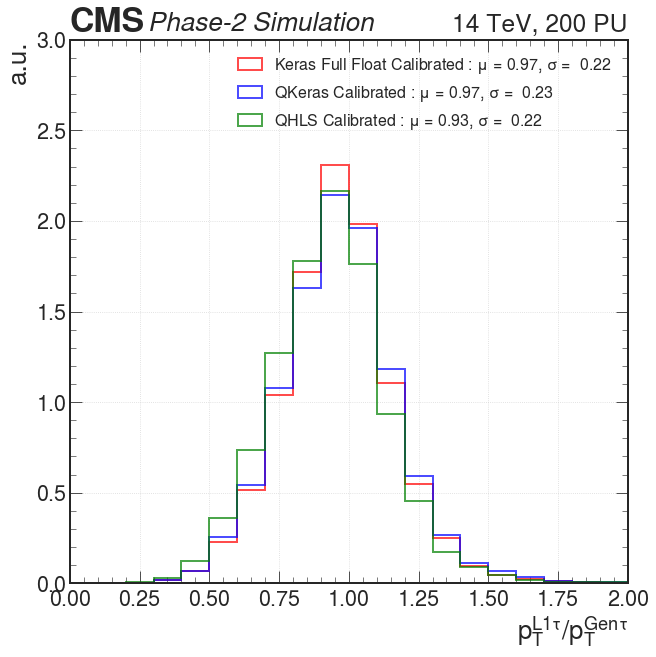

In [17]:
plt.figure(figsize=(10,10))
plt.hist(response_ff,       bins=np.arange(0,5,0.1), label=r'Keras Full Float Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_ff), np.std(response_ff)), color='red', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'QHLS Calibrated : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [18]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 14:00:20 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:25 ; elapsed = 00:00:29 . Memory (MB): peak = 1119.492 ; gain = 597.402 ; free physical = 302139 ; free virtual = 374989
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::concatenate1d<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_merge.h:170:44).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config6>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'PartitionLoop' (firmware/nnet_utils/nnet_conv2d_latency.h:196) in function 'nnet::conv_2d_cl<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' for pipelining.
IN

INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'mult.V' (firmware/nnet_utils/nnet_conv2d_latency.h:183) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'acc.V' (firmware/nnet_utils/nnet_conv2d_latency.h:186) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'w5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b5.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool.V' (firmware/nnet_utils/nnet_pooling.h:228) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'data_buf.i'  in dimension 2 completely.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEE

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:03:09 ; elapsed = 00:03:14 . Memory (MB): peak = 3099.430 ; gain = 2577.340 ; free physical = 301031 ; free virtual = 373891
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'fill_buffer_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'fill_buffer.1'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 194.66 seconds; current allocated memory: 780.948 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 7 seconds; current allocated memory: 965.704 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_fixed<16,7,0,0,0>,relu_config6>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 6.34 seconds; current allocated memory: 967.828 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-arc

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_51_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_52_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_53_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_54_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_55_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_56_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_57_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_58_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_59_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer9_out_60_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproj

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_60_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_61_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_62_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_63_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_64_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_65_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_66_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_67_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_68_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_69_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_150_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_151_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_152_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_153_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_154_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_155_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_156_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_157_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_158_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_159_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_240_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_241_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_242_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_243_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_244_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_245_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_246_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_247_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_248_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_249_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_326_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_327_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_328_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_329_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_330_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_331_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_332_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_333_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_334_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_335_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_414_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_415_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_416_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_417_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_418_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_419_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_420_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_421_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_422_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_423_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_501_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_502_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_503_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_504_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_505_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_506_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_507_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_508_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_509_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_510_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_75_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_76_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_77_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_78_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_79_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_80_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_81_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_82_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_83_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_84_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_162_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_163_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_164_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_165_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_166_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_167_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_168_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_169_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_170_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_171_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_249_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_250_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_251_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_252_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_253_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_254_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_255_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_256_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_257_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_258_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_336_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_337_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_338_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_339_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_340_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_341_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_342_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_343_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_344_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_345_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_421_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_422_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_423_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_424_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_425_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_426_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_427_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_428_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_429_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_430_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285]

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_506_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_507_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_508_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_509_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_510_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_511_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_0_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_1_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_2_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_3_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Impleme

INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_79_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_80_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_81_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_82_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_83_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_84_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_85_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_86_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_87_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer4_out_88_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_38_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_39_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_40_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_41_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_42_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_43_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_44_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_45_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_46_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer5_out_47_V_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_52_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_53_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_54_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_55_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_56_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_57_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_58_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_59_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_60_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer6_out_61_V_U(fifo_w15_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implement

INFO: [Synth 8-256] done synthesizing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s' (3#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s.vhd:1048]
INFO: [Synth 8-3491] module 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s.vhd:12' bound to instance 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_U0' of component 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:13888]
INFO: [Synth 8-638] synthesizing module 'poolin

INFO: [Synth 8-256] done synthesizing module 'pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s' (6#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/pooling2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config4_s.vhd:664]
INFO: [Synth 8-638] synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:224]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:296]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_1_1_1' (8#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_1_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 1 - type: integer 
	Parameter din1_WIDTH bound to: 1 - type: integer 
	Parameter din2_WIDTH bound to: 1 - type: integer 
	Parameter din3_WIDTH bound to: 1 - type: integer 
	Parameter din4_WIDTH bound to: 1 - type: integer 
	Parameter din5_WIDTH bound to: 1 - type: integer 
	Parameter din6_WIDTH bound to: 1 - type: integer 
	Parameter din7_WIDTH bound to: 1 - type: integer 
	Parameter din8_WIDTH bound to: 1 - type: integer 
	Parameter din9_WIDTH bound to: 1 - type: integer 
	Parameter din10_WIDTH bound to: 1 - type: integer 
	Parameter din11_WIDTH bound to: 1 - type: integer 
	Parameter din12_WIDTH

	Parameter din31_WIDTH bound to: 1 - type: integer 
	Parameter din32_WIDTH bound to: 1 - type: integer 
	Parameter din33_WIDTH bound to: 1 - type: integer 
	Parameter din34_WIDTH bound to: 1 - type: integer 
	Parameter din35_WIDTH bound to: 1 - type: integer 
	Parameter din36_WIDTH bound to: 1 - type: integer 
	Parameter din37_WIDTH bound to: 1 - type: integer 
	Parameter din38_WIDTH bound to: 1 - type: integer 
	Parameter din39_WIDTH bound to: 1 - type: integer 
	Parameter din40_WIDTH bound to: 1 - type: integer 
	Parameter din41_WIDTH bound to: 1 - type: integer 
	Parameter din42_WIDTH bound to: 1 - type: integer 
	Parameter din43_WIDTH bound to: 1 - type: integer 
	Parameter din44_WIDTH bound to: 1 - type: integer 
	Parameter din45_WIDTH bound to: 1 - type: integer 
	Parameter din46_WIDTH bound to: 1 - type: integer 
	Parameter din47_WIDTH bound to: 1 - type: integer 
	Parameter din48_WIDTH bound to: 1 - type: integer 
	Parameter din49_WIDTH bound to: 1 - type: integer 
	Parameter d

INFO: [Synth 8-256] done synthesizing module 'myproject_mux_1287_16_1_1' (9#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject_mux_1287_16_1_1.vhd:277]
	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Paramet

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17

	Parameter ID bound to: 1 - type: integer 
	Parameter NUM_STAGE bound to: 1 - type: integer 
	Parameter din0_WIDTH bound to: 16 - type: integer 
	Parameter din1_WIDTH bound to: 16 - type: integer 
	Parameter din2_WIDTH bound to: 16 - type: integer 
	Parameter din3_WIDTH bound to: 16 - type: integer 
	Parameter din4_WIDTH bound to: 16 - type: integer 
	Parameter din5_WIDTH bound to: 16 - type: integer 
	Parameter din6_WIDTH bound to: 16 - type: integer 
	Parameter din7_WIDTH bound to: 16 - type: integer 
	Parameter din8_WIDTH bound to: 16 - type: integer 
	Parameter din9_WIDTH bound to: 16 - type: integer 
	Parameter din10_WIDTH bound to: 16 - type: integer 
	Parameter din11_WIDTH bound to: 16 - type: integer 
	Parameter din12_WIDTH bound to: 16 - type: integer 
	Parameter din13_WIDTH bound to: 16 - type: integer 
	Parameter din14_WIDTH bound to: 16 - type: integer 
	Parameter din15_WIDTH bound to: 16 - type: integer 
	Parameter din16_WIDTH bound to: 16 - type: integer 
	Parameter din17

INFO: [Synth 8-256] done synthesizing module 'conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s' (12#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/conv_2d_cl_ap_fixed_ap_fixed_16_7_5_3_0_config5_s.vhd:224]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s.vhd:168]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config6_s.vhd:178]
INFO: [Synth 8-5534] Detected attribute (* fsm_encoding = "none" *) [/grid_mnt/data__

INFO: [Synth 8-4490] FSM extraction disabled for register 'ap_CS_fsm_reg' through user attribute
INFO: [Synth 8-5818] HDL ADVISOR - The operator resource <adder> is shared. To prevent sharing consider applying a KEEP on the output of the operator [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QCNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/fifo_w32_d6_A.vhd:102]
---------------------------------------------------------------------------------
Finished RTL Optimization Phase 2 : Time (s): cpu = 00:01:18 ; elapsed = 00:01:14 . Memory (MB): peak = 3274.836 ; gain = 1651.848 ; free physical = 293417 ; free virtual = 366757
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+--------

	   2 Input     15 Bit        Muxes := 1     
Module fifo_w15_d2_A__338 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w15_d2_A_shiftReg__339 
Detailed RTL Component Info : 
+---Registers : 
	               15 Bit    Registers := 2     
+---Muxes : 
	   2 Input     15 Bit        Muxes := 1     
Module fifo_w15_d2_A__339 
Detailed RTL Component Info : 
+---Adders : 
	   2 Input      2 Bit       Adders := 1     
+---Registers : 
	                2 Bit    Registers := 1     
	                1 Bit    Registers := 2     
+---Muxes : 
	   2 Input      1 Bit        Muxes := 3     
Module fifo_w15_d2_A_shiftReg__340 
Detailed RTL Component Info : 
+---Registers : 
	               15 Bit    Registers := 2     
+---Muxes : 
	   2 Input     15 Bit        Muxes := 1     
Modu

No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_4_fu_4122_p2, operation Mode is: A*(B:0x13).
DSP Report: operator mul_ln1118_4_fu_4122_p2 is absorbed into DSP mul_ln1118_4_fu_4122_p2.
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2096]' (FD) to 'grp_fill_buffer_1_fu_7357/tmp_130_reg_5639_reg[0]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2097]' (FD) to 'grp_fill_buffer_1_fu_7357/tmp_130_reg_5639_reg[1]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2098]' (FD) to 'grp_fill_buffer_1_fu_7357/tmp_130_reg_5639_reg[2]'
INFO: [Synth 8-3886] merging instance 'grp_fill_buffer_1_fu_7357/data_V_read_1_reg_5592_reg[2099]' (FD) to 'grp_fil

---------------------------------------------------------------------------------
Finished Cross Boundary and Area Optimization : Time (s): cpu = 00:02:31 ; elapsed = 00:02:38 . Memory (MB): peak = 3586.004 ; gain = 1963.016 ; free physical = 289979 ; free virtual = 363573
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+--------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                       | DSP Mapping   | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+--------------------------------------------------+

INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_117_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_116_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_115_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_114_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_112_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_111_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (layer4_out_110_V_U/\U_fifo_w16_d2_A_shiftReg/SRL_SIG_reg[1][15] )
INFO: [Common 17-14] Message 'Synth 8-333

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Final Netlist Cleanup
---------------------------------------------------------------------------------
-------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:04:21 ; elapsed = 00:04:37 . Memory (MB): peak = 3722.129 ; gain = 2099.141 ; free physical = 296200 ; free virtual = 370031
Synthesis Optimization Complete : Time (s): cpu = 00:04:21 ; elapsed = 00:04:37 . Memory (MB): peak = 3722.129 ; gain = 2099.141 ; free physical = 296217 ; free virtual = 370030
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:01 ; elapsed = 00:00:01 . Memory (MB): peak = 3722.129 ; gain = 0.000 ; free physical = 296083 ; free virtual = 369897
INFO: [Netlist 29-17] Analyzing 4922 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.02 ; elapsed = 00:00:00.02 . Memory (MB): peak = 3766.246 ; gain = 0.000 ; free physical = 295970 ; free virtual

In [19]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 14:16:53 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNIdentifier5x9Training_lTauPtCut18/QDNNmodel0p6Pruned_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/motta/Phase2L

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:24 ; elapsed = 00:00:28 . Memory (MB): peak = 1121.438 ; gain = 599.348 ; free physical = 301632 ; free virtual = 374981
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:26).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<10, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:71) by setting 'biases[15].V' to 'b4.V.15'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (a

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[19].V' to 'b2.V.19'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[20].V' to 'b2.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dens

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:02:13 ; elapsed = 00:02:19 . Memory (MB): peak = 5469.277 ; gain = 4947.188 ; free physical = 299190 ; free virtual = 372547
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 140.53 seconds; current allocated memory: 387.838 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO

INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 2.62 seconds; current allocated memory: 443.082 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 8.8 seconds; current allocated memory: 494.040 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:08 . Memory (MB): peak = 1940.215 ; gain = 317.406 ; free physical = 298516 ; free virtual = 371944
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:06 ; elapsed = 00:00:09 . Memory (MB): peak = 1955.051 ; gain = 332.242 ; free physical = 298526 ; free virtual = 371955
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_61_fu_1352_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_61_fu_1352_p2 is absorbed into DSP mul_ln1118_61_fu_1352_p2.
DSP Report: Generating DSP mul_ln1118_60_fu_845_p2, operation Mode is: A*(B:0x17).
DSP Report: operator mul_ln1118_60_fu_845_p2 is absorbed into DSP mul_ln1118_60_fu_845_p2.
DSP Report: Generating DSP mul_ln1118_59_fu_791_p2, operati


Report RTL Partitions: 
+------+-------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                      |Replication |Instances |
+------+-------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB0 |           1|     23189|
|2     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB1 |           1|      5838|
|3     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB2 |           1|      7103|
|4     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB3 |           1|      6236|
|5     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB4 |           1|     10666|
|6     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB5 |           1|     10449|
|7     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_

---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:02 ; elapsed = 00:02:19 . Memory (MB): peak = 2980.613 ; gain = 1357.805 ; free physical = 291238 ; free virtual = 364742
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Renaming Generated Ports
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Renaming Generated Ports : Time (s): cpu = 00:01:02 ; elapsed = 00:02:19 . Memory (MB): peak = 2980.613 ; gain = 1357.805 ; free physical = 291233 ; free virtual = 364736
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Handling Custom Attributes
-

In [20]:
synth = True
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Tue Sep 27 14:23:12 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p6Pruned_HLS'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/data__data.polcms/cms/mo

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [HLS 200-489] Unrolling loop 'Product2' (firmware/nnet_utils/nnet_dense_latency.h:61) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 74u>, nnet::array<ap_fixed<18, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<18, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<12, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<11, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activati

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_32u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,32u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.8 seconds; current allocated memory: 428.853 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.54 seconds; current allocated memory: 431.443 MB.
INFO: [HLS 200-10] --------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_12_8_5_3_0_16u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_12_8_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 2.83 seconds; current allocated memory: 561.455 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 1.81 seconds; current allocated memory: 565.275 MB.
INFO: [HLS 200-10] -------------------------------------------------------------

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_70_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_71_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_72_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_73_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer6_out_V_data_0_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on function 'myproject' to 'ap_ctrl_hs'.
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_12_8_5_3_0_16u_config4_U0' to 'start_for_dense_array_array_ap_fixed_12_8_5_3_0_16u_confibkb' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0'

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_18_7_5_3_0_32u_config2_s' (5#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_18_7_5_3_0_32u_config2_s.vhd:345]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_32u_relu_config3_s' declared at '/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_32u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_32u_relu_config3_U0' of component 'relu_array_array_ap_fixed_32u_relu_config3_s' [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:2290]
INFO: [Synth 8-638] synthesizing modul

INFO: [Synth 8-256] done synthesizing module 'start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_conficud' (27#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_conficud.vhd:66]
INFO: [Synth 8-256] done synthesizing module 'myproject' (28#1) [/grid_mnt/data__data.polcms/cms/motta/Phase2L1T/2022_09_14_v9/TauCNNCalibrator5x9Training_lTauPtCut18_uEtacut1.5/QDNNmodel0p6Pruned_HLS/myproject_prj/solution1/syn/vhdl/myproject.vhd:248]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:06 ; elapsed = 00:00:09 . Memory (MB): peak = 1955.215 ; gain = 332.367 ; free physical = 298356 ; free virtual = 371918
---------------------------------------------------------------------------------
----------------------------------------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_99_fu_1561_p2, operation Mode is: A*(B:0x13).
DSP Report: operator mul_ln1118_99_fu_1561_p2 is absorbed into DSP mul_ln1118_99_fu_1561_p2.
DSP Report: Generating DSP mul_ln1118_92_fu_1427_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_92_fu_1427_p2 is absorbed into DSP mul_ln1118_92_fu_1427_p2.
DSP Report: Generating DSP mul_ln1118_108_fu_1529_p2, op


Report RTL Partitions: 
+------+----------------------------------------------------------+------------+----------+
|      |RTL Partition                                             |Replication |Instances |
+------+----------------------------------------------------------+------------+----------+
|1     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB0 |           1|     21270|
|2     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB1 |           1|      4645|
|3     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB2 |           1|      7989|
|4     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB3 |           1|      5105|
|5     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB4 |           1|      9343|
|6     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB5 |           1|     20282|
|7     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_config2_s__GB6 |           1|      9427|
|8     |dense_wrapper_ap_fixed_ap_fixed_18_7_5_3_0_conf


Report Check Netlist: 
+------+------------------+-------+---------+-------+------------------+
|      |Item              |Errors |Warnings |Status |Description       |
+------+------------------+-------+---------+-------+------------------+
|1     |multi_driven_nets |      0|        0|Passed |Multi driven nets |
+------+------------------+-------+---------+-------+------------------+
---------------------------------------------------------------------------------
Start Rebuilding User Hierarchy
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:00 ; elapsed = 00:02:16 . Memory (MB): peak = 2980.816 ; gain = 1357.969 ; free physical = 290989 ; free virtual = 364649
---------------------------------------------------------------------------------
----------------------------------------------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:01:03 ; elapsed = 00:02:18 . Memory (MB): peak = 2984.723 ; gain = 1361.875 ; free physical = 297251 ; free virtual = 370912
Synthesis Optimization Complete : Time (s): cpu = 00:01:03 ; elapsed = 00:02:18 . Memory (MB): peak = 2984.723 ; gain = 1361.875 ; free physical = 297266 ; free virtual = 370921
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.45 ; elapsed = 00:00:00.45 . Memory (MB): peak = 2996.961 ; gain = 0.000 ; free physical = 297214 ; free virtual = 370868
INFO: [Netlist 29-17] Analyzing 4445 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3220.012 ; gain = 0.000 ; free physical = 297071 ; free v